# Using `memento` to analyze Interferon-B response in monocytes

To install `memento` in the pre-release version (for Ye Lab members), install it directly from github by running:

```pip install git+https://github.com/yelabucsf/scrna-parameter-estimation.git@release-v0.0.3```

This requires that you have access to the Ye Lab organization. 

In [1]:
# This is only for development purposes

import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
import memento
import matplotlib.pyplot as plt

In [35]:
import scanpy as sc
import memento
import pandas as pd
import seaborn as sns

In [3]:
fig_path = '~/Github/scrna-parameter-estimation/figures/fig4/'
data_path = '/data_volume/parameter_estimation/'

In [4]:
import pickle as pkl

### Read IFN data and filter for monocytes

For `memento`, we need the raw count matrix. Preferrably, feed the one with all genes so that we can choose what genes to look at. 

One of the columns in `adata.obs` should be the discrete groups to compare mean, variability, and co-variability across. In this case, it's called `stim`. 

The column containing the covariate that you want p-values for should either:
- Be binary (aka the column only contains two unique values, such as 'A' and 'B'. Here, the values are either 'stim' or 'ctrl'.
- Be numeric (aka the column contains -1, 0, -1 for each genotype value). 

I recommend changing the labels to something numeric (here, i use 0 for `ctrl` and 1 for `stim`). Otherwise, the sign of the DE/EV/DC testing will be very hard to interpret.

In [5]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
print(adata)

AnnData object with n_obs × n_vars = 5341 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'cell_type'
    var: 'gene_ids', 'mt', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors'
    obsm: 'X_tsne'


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [6]:
adata.obs['stim'] = adata.obs['stim'].apply(lambda x: 0 if x == 'ctrl' else 1)

In [7]:
adata.obs[['ind', 'stim', 'cell']].sample(5)

,ind,stim,cell
index,,,
GATGCAACACCAGT-1,1244,0,CD14+ Monocytes
TATGGTCTTAAAGG-1,1015,1,CD14+ Monocytes
GGTCTAGAGTCCTC-1,1256,0,CD14+ Monocytes
CGAATCGAAACGAA-1,1015,0,CD14+ Monocytes
TGCAAGACCTTGCC-1,1256,0,CD14+ Monocytes


### Create groups for hypothesis testing and compute 1D parameters

`memento` creates groups of cells based on anything that should be considered a reasonable group; here, we just divide the cells into `stim` and `ctrl`. But we can easily further divide the cells into individuals by adding the `ind` column to the `label_columns` argument when calling `create_groups`.

Values in the `q_column` is the rough estimate of the overall UMI efficiency across both sampling and sequencing. If `s` is the sequencing saturation, multiply `s` by 0.07 for 10X v1, 0.15 for v2, and 0.25 for v3. This allows you to enter different numbers for each batch, which likely have different saturation numbers. This will NOT account for wildly different sequencing scenarios.

By default, `memento` will consider all genes whose expression is high enough to calculate an accurate variance. If you wish to include less genes, increase `filter_mean_thresh`.

In [8]:
from scipy.sparse.csr import csr_matrix

In [9]:
type(adata.X) == csr_matrix

True

In [10]:
adata.obs['capture_rate'] = 0.07
memento.setup_memento(adata, q_column='capture_rate')

In [11]:
adata.obs.columns

Index(['tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt',
       'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb',
       'pct_counts_hb', 'cell_type', 'capture_rate', 'memento_size_factor'],
      dtype='object')

In [12]:
memento.create_groups(adata, label_columns=['stim', 'ind'])

In [13]:
memento.compute_1d_moments(adata,
    min_perc_group=.9) # percentage of groups that satisfy the condition for a gene to be considered. 

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log


### For a given gene identified, extract mean and residual variance estimates

IFI6 was a gene identified previously as a gene that was upregulated but decreased in variability. To make a boxplot with the measurements later on, we extract the actual mean and residual variance estimates for each person (biological replicate).

Each column is the estimated mean/residual variance in a stim-individual sample. Since there are 8 donors and 2 conditions, we have 16 total columns (aside from the column containing the gene name). The naming convention is as follows: `sg^{identifier from 1st label}^{identifier from 2nd labe}^...^{identifier from last label}`. Here `0/1` indicates the control/stim state and the numbers in the last slot represents individuals.

In [17]:
mean, var, counts = memento.get_1d_moments(adata)

In [19]:
mean.query('gene == "IFI6"')

,gene,sg^0^1016,sg^0^1256,sg^0^1015,sg^0^101,sg^0^1244,sg^0^1488,sg^0^1039,sg^0^107,sg^1^101,sg^1^1016,sg^1^1256,sg^1^1244,sg^1^1488,sg^1^1015,sg^1^1039,sg^1^107
30,IFI6,-0.449227,-0.532727,-0.29489,-1.532139,-2.166672,-2.352759,-0.336808,-2.352657,1.946561,1.933126,1.973464,1.998504,1.89836,1.951489,1.951971,2.077048


In [20]:
var.query('gene == "IFI6"')

,gene,sg^0^1016,sg^0^1256,sg^0^1015,sg^0^101,sg^0^1244,sg^0^1488,sg^0^1039,sg^0^107,sg^1^101,sg^1^1016,sg^1^1256,sg^1^1244,sg^1^1488,sg^1^1015,sg^1^1039,sg^1^107
30,IFI6,1.627829,1.116948,1.020932,1.465124,0.954609,0.53937,0.574732,2.122171,-0.936025,-0.475878,-0.867462,-0.874124,-0.780617,-0.758113,-0.956405,-0.607123


### Create a figure with estimated moments

In [25]:
ctrl_cols = [c for c in mean.columns if '^0^' in c]
stim_cols = [c for c in mean.columns if '^1^' in c]

In [32]:
mean_ctrl, mean_stim = mean.query('gene == "IFI6"')[ctrl_cols].values.reshape(-1), mean.query('gene == "IFI6"')[stim_cols].values.reshape(-1)
var_ctrl, var_stim = var.query('gene == "IFI6"')[ctrl_cols].values.reshape(-1), var.query('gene == "IFI6"')[stim_cols].values.reshape(-1)

In [38]:
#make longform DataFrame for plotting. There are many ways to do this, this just lets you use seaborn in a straightforward way
df1 = pd.DataFrame()
df1['mean'] = mean_ctrl
df1['var'] = var_ctrl
df1['condition'] = 'ctrl'
df2 = pd.DataFrame()
df2['mean'] = mean_stim
df2['var'] = var_stim
df2['condition'] = 'stim'
df = pd.concat([df1, df2])

<AxesSubplot:xlabel='condition', ylabel='var'>

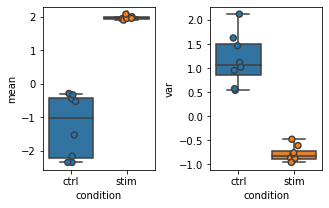

In [58]:
plt.figure(figsize=(5,3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
sns.boxplot(x='condition', y='mean',data=df)
sns.stripplot(x='condition', y='mean',data=df, edgecolor='gray', s=6, linewidth=1.5)
plt.subplot(1, 2, 2)
sns.boxplot(x='condition', y='var',data=df)
sns.stripplot(x='condition', y='var',data=df, edgecolor='gray', s=6, linewidth=1.5)